<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

<hr style="height:2px;border:none"/>

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras stuff
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, rmsprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

Using TensorFlow backend.


In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,stratify=y_train,random_state=42)

## a)
Visualice los datos que trabajaremos e intentaremos detectar en esta sección. ¿Qué dimensiones tienen las imágenes trabajadas? ¿Existen patrones similares entre los objetos de una misma clase? ¿Entre objetos de distintas clases?.

In [3]:
print(x_train.shape)

(45000, 32, 32, 3)


Las imágenes son de 32x32 pixeles, cada una con el canal RGB.

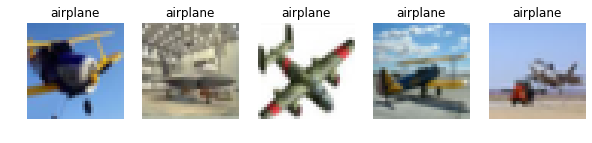

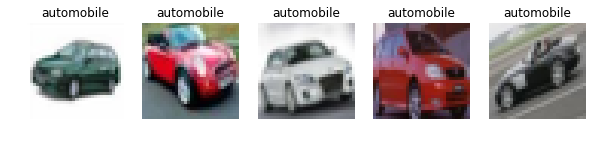

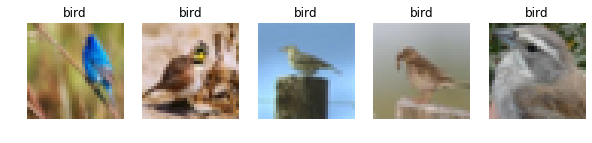

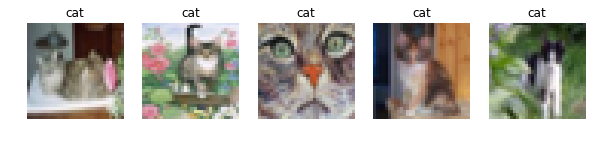

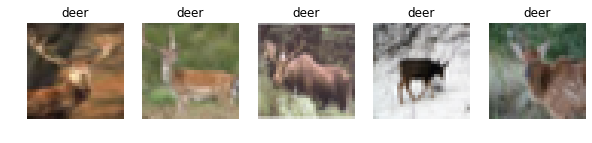

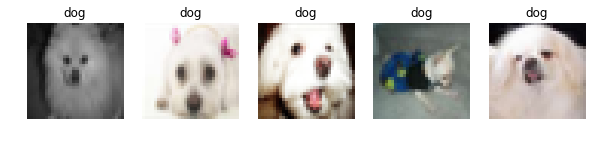

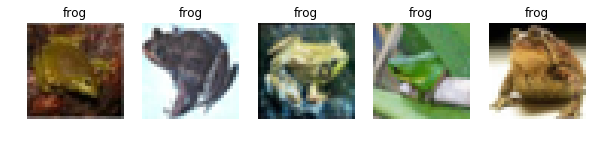

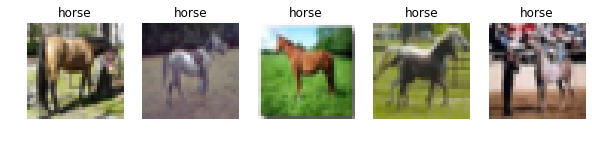

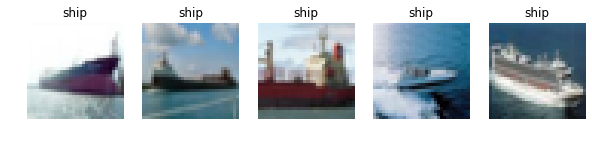

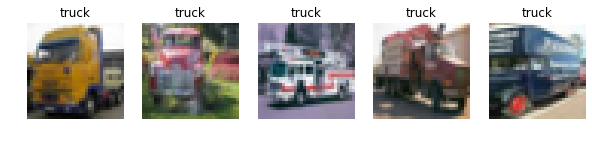

In [4]:
def chart_5_examples_of_class(class_number):
    idx_dato = [np.random.choice(np.where(y_train==class_number)[0]) for i in range(5)]
    f,axx = plt.subplots(1,5,figsize=(10,5))
    for i, dato in enumerate(idx_dato):
        axx[i%5].imshow(x_train[dato])
        axx[i%5].axis('off')
        axx[i%5].set_title(label_names[class_number])
    plt.show()
    
for i in range(10):
    chart_5_examples_of_class(i)

Se aprecia que en las imágenes están todos los objetos en general solos y a plean luz del día. Los objetos pueden estar en distintas perspectivas.

## b)
Prepare los subconjuntos de entrenamiento, validación y pruebas para ser entregados al modelo. Para ésto divida la intensidad original de pixel en cada canal por 255. Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’th’ (por defecto para *Theano*) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

In [5]:
# x_train = x_train.transpose([0, 3, 1, 2]) #if 'th' dim-ordering is used
# x_test= x_test.transpose([0, 3, 1, 2]) 

import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
Xnorm_train = x_train.astype('float32')/255
Xnorm_val = x_val.astype('float32')/255
Xnorm_test = x_test.astype('float32')/255

## c)
Defina una CNN simple con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 32 y 64 filtros de $3 \times 3$ y funciones de activación ReLU respectivamente. Para las capas de *pooling* utilice filtros de $2 \times 2$ con *stride* 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass* y el número de parámetros de cada capa.

In [6]:
def get_ann_b_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model = get_ann_b_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dens

## d) 
Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior con una tasa de decaimiento, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema compare el entrenar con un optimizador adaptativo como es **RMSProp** con parámetros similares. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

In [7]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

model_d_sdg = get_ann_b_model()
model_d_rmsprop = get_ann_b_model()

model_d_sdg.compile(optimizer = SGD(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_d_sdg = model_d_sdg.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

Instructions for updating:
Use tf.cast instead.


In [9]:
model_d_rmsprop.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_d_rmsprop = model_d_rmsprop.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val, y_val))

In [17]:
def chart_metric(history,metric_name, epoch_number = 50):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history[metric_name], '.-')
    plt.plot(epoch_arr, history.history['val_'+metric_name], '.-')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend( ('Train', 'Val') )
    
    if metric_name == 'acc':
        max_index = np.argmax(history.history['val_'+metric_name])
        max_value = history.history['val_'+metric_name][max_index].round(2)
        plt.annotate('Max = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, -100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))

    plt.show()

In [ ]:
print("SDG")
chart_metric(history_d_sdg, "loss", 25)
chart_metric(history_d_sdg, "acc", 25)
print("RMSProp")
chart_metric(history_d_rmsprop, "loss", 25)
chart_metric(history_d_rmsprop, "acc", 25)

In [19]:
np.shape(history_d_sdg.history['val_loss'])

(25,)

Al ver los gráficos después de entrenar con 25 epochs, se corrobora que el entrenamiento con SGD es más lento y que un algoritmo adaptivo como RMSProp mejora la rapidez de convergencia en el entrenamiento. En particular con 25 epochs en ambos casos se ve que van aprendiendo ya que la función de perdida decrementa, pero en RMSProp, en cada iteración lo decrementa más, mientras que en SGD es lineal.

Al ver la comparación del accuracy, la versión con SGD obtiene 0.16 como valor máximo a la epoch número 25, mientras que la versión con RMSProp obtiene 0.68 de acurracy en la misma cantidad de epochs.

## e)
Ahora bien, para mejorar los resultados encontrados deberá aumentar o reducir el número de capas, dependiendo de qué dice su intuición. Deberá elegir sobre dónde aumentar o reducir el número de capas, la fase convolucional y/o la fase *feed forward*, no olvide que al aumentar el número de capas (como en la sección 2) conlleva ciertas consecuencias, lo más importante el *overfitting*, vea cómo reducir ésto.


In [55]:
def get_ann_e_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Se añade una nueva capa de convolución cn 64 filtros.
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

model_e = get_ann_e_model()
model_e.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_e = model_e.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

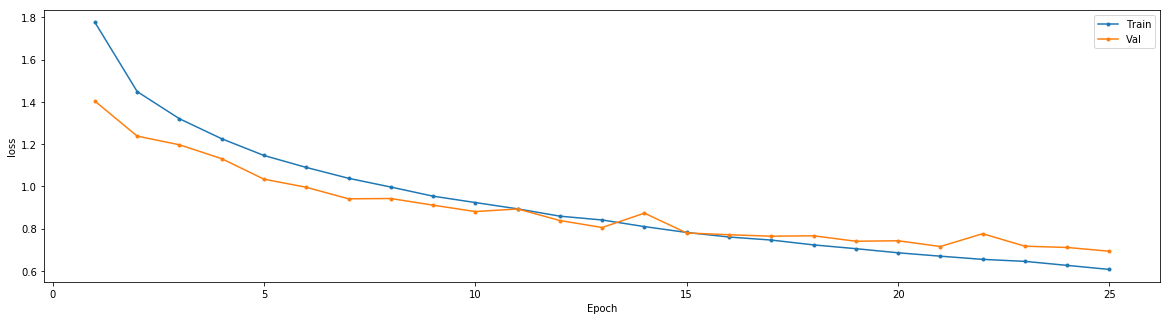

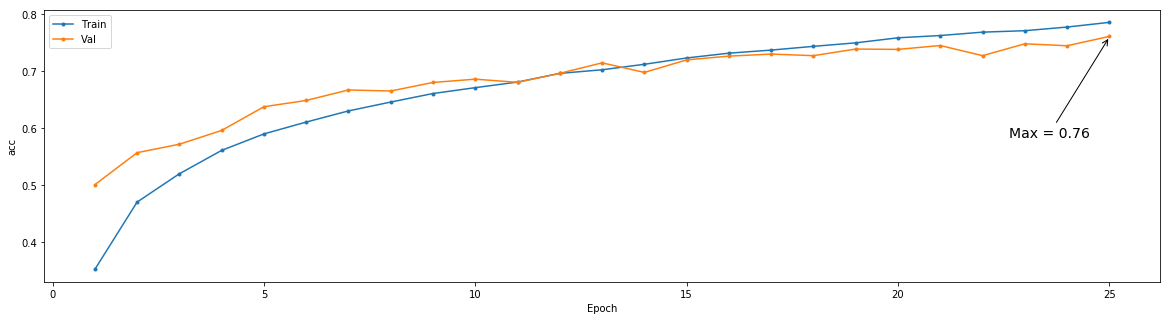

In [56]:
chart_metric(history_e, "loss", 25)
chart_metric(history_e, "acc", 25)

Se añade 1 nueva capa convolucional y una capa densa. Para mitigar el overfittin se decide ocupar ambos métodos de regularización *Batch normalization* y *Dropout* siguiendo las recomendaciones del articulo *"Don’t Use Dropout in Convolutional Networks."* [[1]](#ref). Efectivamente se mejora el resultado obtenido ya que se mejora el accuracy de 0,68 a 0,76.

## f)
Duplique el tamaño de los filtros utilizados en la primera capa convolucional. ¿Qué efecto tiene esto sobre el tipo de patrones que detectará la red? ¿Porqué usar filtros pequeños no impide detectar patrones más grandes?

In [57]:
def get_ann_f_model():
    model = Sequential()
    model.add(Conv2D(32, (3 * 3, 3 * 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (3 * 3, 3 * 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model_f = get_ann_f_model()
model_f.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_f = model_f.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

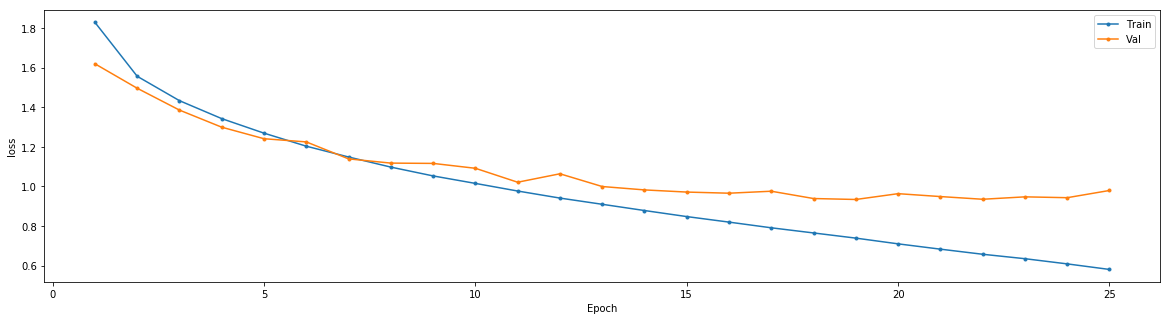

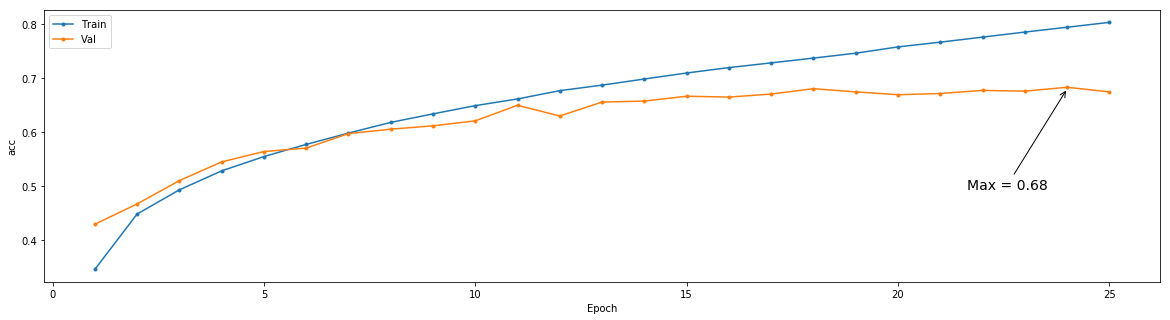

In [58]:
chart_metric(history_f, "loss", 25)
chart_metric(history_f, "acc", 25)

## g)
Duplique el número de filtros utilizados en las capas convolucionales. ¿Qué efecto tiene esto sobre la capacidad de aprendizaje de la red?

In [62]:
def get_ann_f_model():
    model = Sequential()
    model.add(Conv2D(32 * 2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64 * 2, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model_g = get_ann_f_model()
model_g.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_g = model_g.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

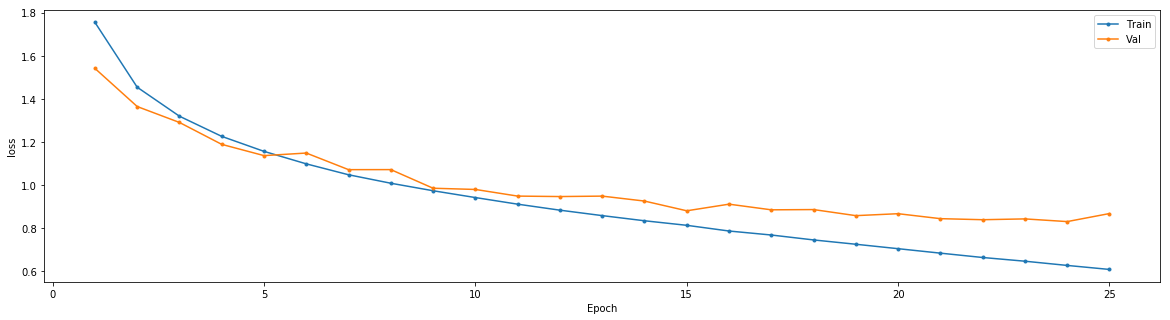

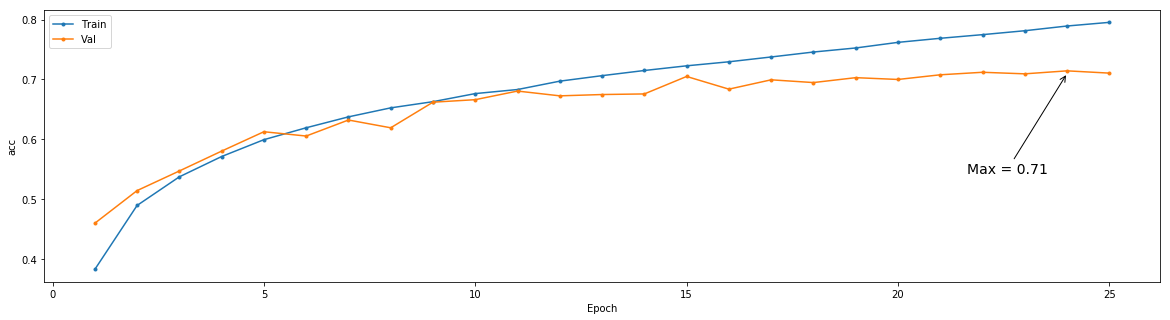

In [63]:
chart_metric(history_g, "loss", 25)
chart_metric(history_g, "acc", 25)

Al aumentar la cantidad de filtros se esperaria que la red pudiera aprender más caracteristicas a reconocer, por lo tanto debiese aumentar su poder de predicción/clasificación. Al ver los resultados obtenidos, efectivamente éste mejora, llegando a conseguir un accuracy del 0,71.

## h)
Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 32 filtros para la primera capa convolucional y 64 para la segunda.  Como resultado final de esta actividad, al igual que las otras, grafique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test), pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador ¿Dónde? ¿Qué tan potente?

In [90]:
def get_ann_h_1_model():
    model = Sequential()
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

def get_ann_h_2_model():
    model = Sequential()
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

In [91]:
model_h_1 = get_ann_h_1_model()
model_h_1.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_h_1 = model_h_1.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

In [87]:
model_h_2 = get_ann_h_2_model()
model_h_2.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_h_2 = model_h_2.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

Arquitectura normal


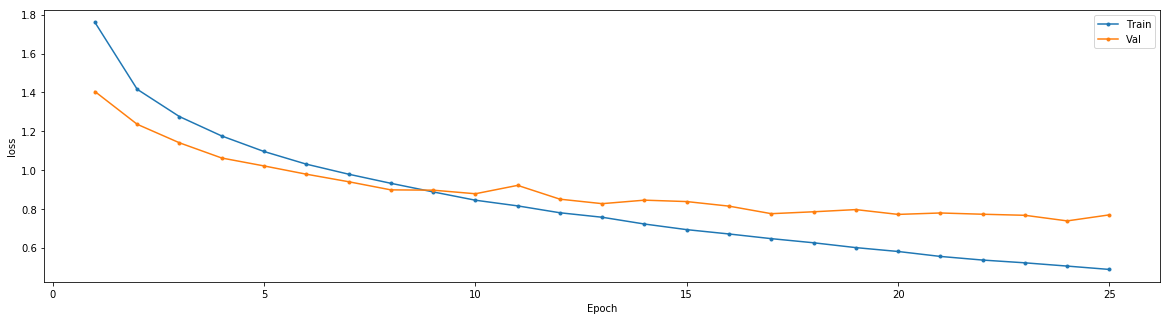

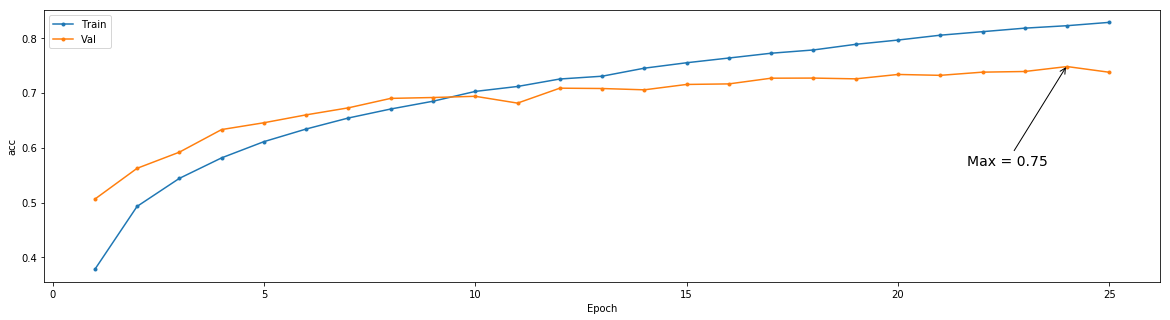

Arquitectura profunda


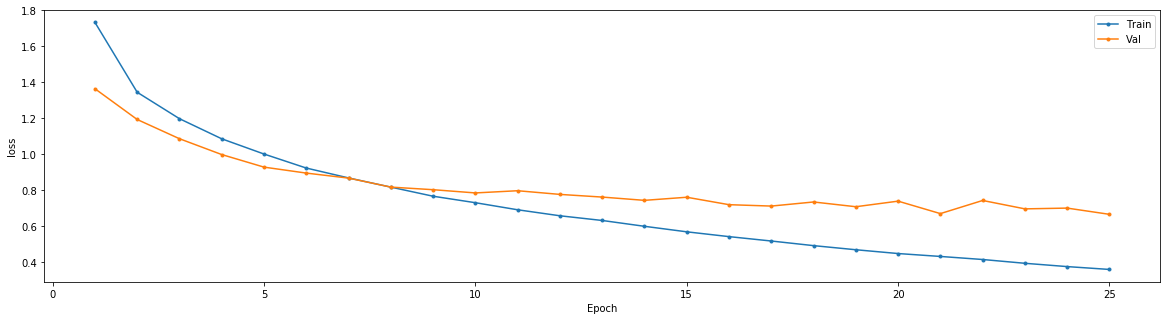

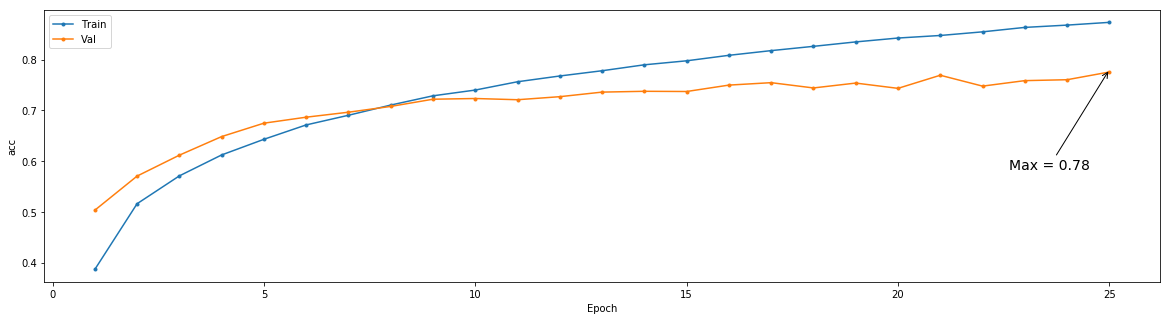

In [92]:
print("Arquitectura normal")
chart_metric(history_h_1, "loss", 25)
chart_metric(history_h_1, "acc", 25)

print("Arquitectura profunda")
chart_metric(history_h_2, "loss", 25)
chart_metric(history_h_2, "acc", 25)

Al ver los gráficos, efectivamente se obtienen modelos con un accuracy superior al 70%. El modelo más profundo tiene un mejor resultado, dando como máximo 0,78 de accuracy (en validación), esto se debe a que tiene más capas detectanto caracteristicas (capas de convolución), entonces se espera que tenga mayor poder de predicción.

Cabe destacar que ambos modelos eran sumamente susceptibles a over-fittin (comente las lineas de batch nomalization y dropout para ver el over-fitting), entonces por eso se decidió ocupar ambos regularizadores, aunque esto amotiguo el over-fitting pero no lo elimina, ya que se ve una clara tendencia a que el accuracy de validación se estanque, mientras que el de entrenamiento sigue subiendo.

La elección de donde poner las capas de batch normalization y dropout se deben a las recomendaciones del artículo *"Don’t Use Dropout in Convolutional Networks."* [[1]](#ref)

## i)
Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con *stride* 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [13]:
def get_ann_i_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(32, (3, 3), strides=2, padding='same', activation='linear'))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(64, (3, 3), strides=2, padding='same', activation='linear'))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

model_i = get_ann_i_model()
model_i.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
__________

Al ver la salida del código anterior se aprecia que al aplicar las capas convolucionales con strides = 2, se reduce la dimensionalidad del input.

In [14]:
model_i.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_i = model_i.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

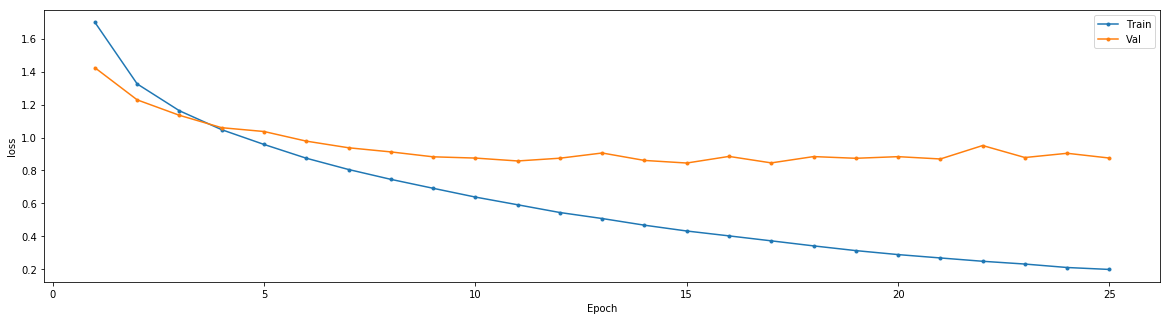

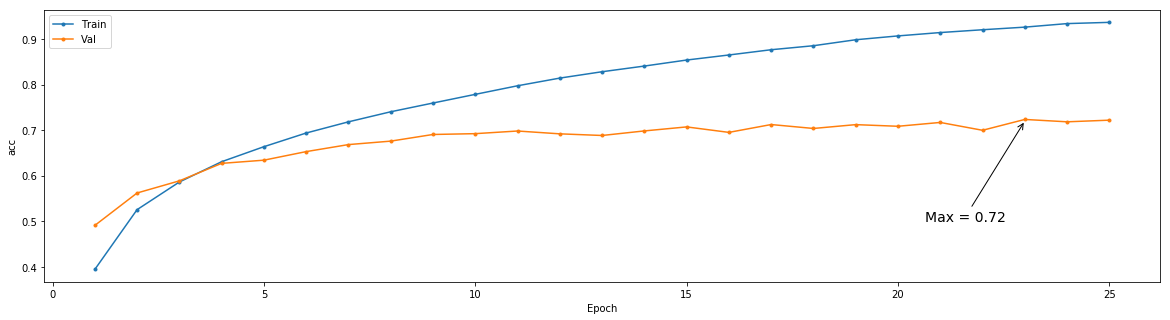

In [18]:
chart_metric(history_i, "loss", 25)
chart_metric(history_i, "acc", 25)

Una red comparable a la propuesta en esta pregunta es la primera arquitectura propuesta en la pregunta **h)** se aprecia que su única diferencia es que en vez de capas de pooling se ocupa convolucionales con strides. 

Al comparar el rendimineto de ambas arquitecturas se aprecia que la arquitectura de la pregunta **h)** da mejores resultados y que la red sin pooling tiene un *over-fitting* aun más pronunciado (el error de entrenamiento llega al 0,9). Esto se debe que al cambiar la capa de pooling por una convolucional se añaden más parámetros, entonces la red opta por un modelo más complejo y pierde poder de generalización.

## j)
Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique por qué este procedimiento podrı́a ayudar a mejorar el modelo y el por qué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(Xnorm_train)
model.fit_generator(datagen.flow(Xnorm_train, y_train,batch_size=batch_size),steps_per_epoch=Xnorm_train.shape[0]// batch_size, epochs=epochs,validation_data=(Xnorm_val, y_val))

## Referencias
- [1] Don’t Use Dropout in Convolutional Networks.. (2018). Towards Data Science. Retrieved 3 May 2019, from https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16


<hr style="height:2px;border:none"/>